# Week 2

In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
from pandas_datareader import data 
from datetime import datetime
from scipy.optimize import minimize

In [347]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [348]:
import edhec_risk_kit as erk

In [349]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

## Modern portfolio theory (MPT)

The **Modern portfolio theory (MPT)** is a mathematical framework **for assembling a portfolio of assets such that the expected return is maximized for a given level of volatility**. It is a formalization of **diversification in investing**, i.e., the idea that owning different kinds of financial assets is less risky than owning only one type. 

### Efficient Frontiers 

In the MPT, The **efficient frontier** is an a curve which occupies the *efficient* part of the **volatility-return** plane. 
Formally, it is the set of portfolios which satisfy the condition that no other portfolio exists with a higher expected 
return but with the same standard deviation of return. 

The efficient frontier was first formulated by **Harry Markowitz** (1952).

### How it works
We have to construct a portfolio of several assets and **we want to find the optimal percentage of investments to be allocated in these assets** so that the overall (expected) return of such a portfolio is maximixed for a given level of volatility. 

Hence, suppose that **we have $k > 1$ assets**, and we decide to invest all of our capital in these assets. 

Let $\mathbf{w}:=(w_1,\dots,w_K)^T$, with $w_i\in (0,1)$ for all $i=1,\dots,K$, 
be the percentages of investment our portfolio, i.e, $w_i$ is the proportion of investiment in asset $i$. 
There holds $\sum_{i=1}^K w_i = 1$. 

Let $R_i$ and $R_p$ be the return of asset $i$ and the total return of the portfolio, respectively. 
Likewise, let $\sigma_i$ and $\sigma_p$ be the volatility of asset $i$ and the volatility of the portfolio, respectively. 


#### Return of a portfolio
The **total return of the porfolio** is going to be a simple weigthed sum of the (total) returns of single assets, i.e.,
$$
R_p = \sum_{i=1}^K w_i R_i = \mathbf{w}^T \mathbf{R},
$$
where $\mathbf{R} := (R_1,\dots,R_K)^T$.


#### Volatility of a portfolio
The **volatility of the porfolio** is computed as the (square root of the) variance of the weigthed sum of the returns of single assets. 

Let us make and axample with only two assets. We have $w_1$ and $w_2$ and two assets whose returns are $R_1$ and $R_2$. We have:
$$
\sigma_p^2 =   \text{Var}(w_1 R_1 + w_2 R_2) = 
w_1^2 \text{Var}(R_1) + w_2^2\text{Var}(R_2) + 2w_1 w_2\text{cov}(R_1,R_2) =
w_1^2 \sigma_1^2 + w_2^2\sigma_2^2 + 2w_1 w_2\text{cov}(R_1,R_2), 
$$
where 
$$
\text{cov}(R_1,R_2) := \mathbb{E}[(R_i-\mu_i)(R_j - \mu_j)], 
$$
is the **covariance** between asset $i$ and $j$ and where $\mu_i$ and $\mu_j$ denote 
the mean returns of assets $i$ and $j$, respectively. In particular, if we let 
$$
\rho_{ij} := \frac{\text{cov}(R_i,R_j)}{\sigma_i \sigma_j} = \frac{\text{cov}(i,j)}{\sigma_i \sigma_j}, 
$$
denote the **correlation coefficient** between assets $i$ and asset $j$, then the volatilityt of a $2$ assets portfolio becomes:
$$
\sigma_p = 
\sqrt{ w_i^2 \sigma_1^2 + w_2^2 \sigma_2^2 + 2w_1 w_2 \sigma_1 \sigma_2 \rho_{ij} }. 
$$


Now, in case of $K$ assets, we can express the volatility as follows. 
Let $\Sigma$ be the **covariance matrix**, that is, a symmetric square $K\times K$ matrix, $\Sigma = [\sigma_{ij}]$, 
where each element $\sigma_{ij} := \sigma_i \sigma_j \rho_{ij}$ ($i,j=1,\dots,K$) denote the **covariance** between assets $i$ and asset $j$, 
where $\sigma_i$, $\sigma_j$, and $\rho_{ij}$ denote the volatility and the correlation coefficient of assets $i$ and $j$, respectively. 
If $i=j$, $\sigma_{ii}=\sigma_i^2$ is simply the variance of asset $i$ (**diagonal entries are simply the variances**).

The resulting volatility is then given by:
$$
\sigma_p = \sqrt{ \mathbf{w}^T \Sigma \mathbf{w} }
$$


### Efficient frontiers of 2-assets portfoliso 
In the following we do a very artificial example in order to see the curve that is drawn by different portfolios which 
are constructed with only $2$ assets with different correalation $\rho_{12}$. 
First of all, we assume to generate $500$ daily returns of $2$ assets:

In [266]:
nret             = 500
periods_per_year = 252
risk_free_rate   = 0.0

Then, we set up a value for the means and the volatility of our two artifical assets:

In [267]:
mean_1 = 0.001019
mean_2 = 0.001249
vol_1  = 0.016317
vol_2  = 0.019129

and we set up the $6$ correlations of the two assets, and for every fixed correlation, 
we will generate $20$ portfolios by allocating $20$ pairs of weights:

In [268]:
# Correlation goes from 1 (completely correlated) to -1 (conversely correlated)
rhos  = np.linspace(1,-1,num=6) 
ncorr = len(rhos)

# Pairs of weights to be used to construct the portfolios for any given correlation
nweig = 20
w1 = np.linspace(0,1,num=nweig)
w2 = 1 - np.linspace(0,1,num=nweig)
ww = pd.DataFrame( [w1, w2] ).T  

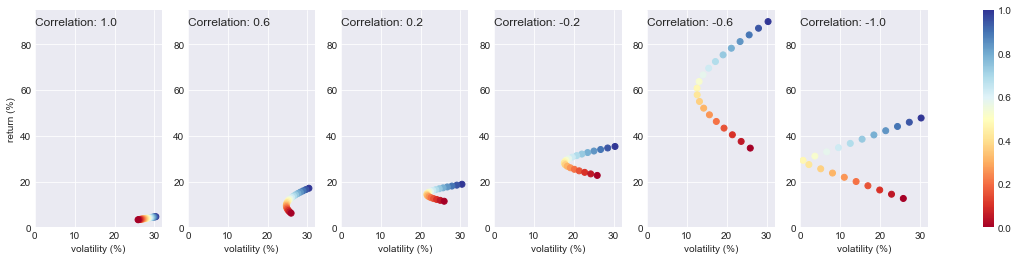

In [269]:
# Set seed
np.random.seed(1)

# Open the figure
fig, ax = plt.subplots(1,6, figsize=(20,4))    
ax = ax.flatten()

for k_rho, rho in enumerate(rhos):
    # Allocate an empty portfolio 
    portfolio = pd.DataFrame(columns=["return","volatility","sharpe ratio"])

    # Generate the assets' returns with the given correlation rho
    cov_ij     = rho * vol_1 * vol_2
    cov_rets   = pd.DataFrame( [[vol_1**2, cov_ij], [cov_ij, vol_2**2]] )
    daily_rets = pd.DataFrame( np.random.multivariate_normal((mean_1,mean_2), cov_rets.values, nret) )
    
    for i in range(ww.shape[0]):
        # Now, construct the portfolio of two asset with correlation rho and weights ww.loc[i]
        weights = ww.loc[i] 
        # here, weights is a column vector (pd.Series)

        # annualized portfolio returns
        ann_rets      = erk.annualize_rets(daily_rets, periods_per_year)
        portfolio_ret = erk.portfolio_return(weights, ann_rets)        

        # annualized portfolio volatility
        portfolio_vol = erk.portfolio_volatility(weights, cov_rets)
        portfolio_vol = erk.annualize_vol(portfolio_vol, periods_per_year)

        # annualized portfolio sharpe ratio
        portfolio_spr = erk.sharpe_ratio(portfolio_ret, risk_free_rate, periods_per_year, v=portfolio_vol)

        # dataframe containing the return, volatility, and the sharpe ratio of the portfolio constructed   
        portfolio = portfolio.append( {"return":portfolio_ret, "volatility": portfolio_vol, "sharpe ratio":portfolio_spr}, ignore_index=True)

    # plot create scatter plot coloured by Sharpe Ratio
    im = ax[k_rho].scatter(portfolio["volatility"]*100, portfolio["return"]*100, c=w2, cmap='RdYlBu') 
    ax[k_rho].grid()
    ax[k_rho].set_title("Correlation: {}".format(np.round(rho,2)), y=0.9, loc='left')
    ax[k_rho].set_xlabel("volatility (%)")
    if k_rho==0: ax[k_rho].set_ylabel("return (%)") 
    ax[k_rho].set_xlim([0,32])
    ax[k_rho].set_ylim([0,95])
    
fig.colorbar(im, ax=ax.ravel().tolist())
plt.show()

For any given correlation, each point represents the pair (return, volatility) of a portfolio constructed with some percentage allocation. 
This can be seen in the colorbar: **red corresponds to $\mathbf{w} = (1,0)$**, i.e., allocation of money only to the first asset, whereas 
**blue corresponds to $\mathbf{w} = (0,1)$**, i.e., allocation of money only ot the second asset.  

We can see that **the lower the correlation between the assets, the better the trade-off between return and volatility**: in this example, 
when $\rho=-1$, we could in principle construct a portfolio which guarantee about $30\%$ of return with almost no volatility.

### Example from the real world: US stocks
Now we will get the timeseries of some US economy stocks and see how to construct a portfolio in an efficient way.

In [341]:
tickers  = ['AMZN','KO','MSFT']
n_assets = len(tickers) 

stocks = pd.DataFrame()
for stock_name in tickers:
    # daily data
    stocks[stock_name] = data.DataReader(stock_name, data_source="yahoo", start=datetime(2010,1,1))["Adj Close"]    

In [342]:
stocks.tail()

,AMZN,KO,MSFT
Date,,,
2019-10-11,1731.920044,53.299999,139.679993
2019-10-14,1736.430054,53.299999,139.550003
2019-10-15,1767.380005,53.509998,141.570007
2019-10-16,1777.430054,53.490002,140.410004
2019-10-17,1790.848267,53.790100,139.940002


In [343]:
# compute the daily returns 
daily_rets = erk.compute_returns(stocks)
daily_rets.tail()

,AMZN,KO,MSFT
Date,,,
2019-10-11,0.006778,-0.006709,0.004170
2019-10-14,0.002604,0.000000,-0.000931
2019-10-15,0.017824,0.003940,0.014475
2019-10-16,0.005686,-0.000374,-0.008194
2019-10-17,0.007549,0.005610,-0.003347


In [344]:
# compute the mean daily returns and the covariance of daily returns of the two assets
mean_rets = daily_rets.mean()
std_rets  = daily_rets.std()
cov_rets  = daily_rets.cov()
cov_rets

,AMZN,KO,MSFT
AMZN,0.000387,0.000047,0.000138
KO,0.000047,0.000087,0.000050
MSFT,0.000138,0.000050,0.000208


Now we simulate $4000$ portfolios with weights allocated to the stocks above:

In [345]:
periods_per_year = 252
num_portfolios   = 4000
portfolios       = pd.DataFrame(columns=["return","volatility","sharpe ratio","w1","w2","w3"])
risk_free_rate   = 0

In [346]:
for i in range(num_portfolios):
    # select random weights
    weights = np.random.random(n_assets)
    # and rescale them to sum to 1
    weights /= np.sum(weights)
    
    # annualized portfolio returns
    ann_rets      = erk.annualize_rets(daily_rets, periods_per_year)
    portfolio_ret = erk.portfolio_return(weights, ann_rets)        

    # annualized portfolio volatility
    portfolio_vol = erk.portfolio_volatility(weights, cov_rets)
    portfolio_vol = erk.annualize_vol(portfolio_vol, periods_per_year)

    # annualized portfolio sharpe ratio
    portfolio_spr = erk.sharpe_ratio(portfolio_ret, risk_free_rate, periods_per_year, v=portfolio_vol)
    
    # create dataframe   
    portfolios = portfolios.append( {"return":portfolio_ret, 
                                     "volatility":portfolio_vol, 
                                     "sharpe ratio":portfolio_spr, 
                                     "w1": weights[0], "w2": weights[1], "w3": weights[2]}, 
                                     ignore_index=True)

Now we create a scatter plot coloured by sharpe ratios of the portfolios generated above and we also plot the efficient frontier 

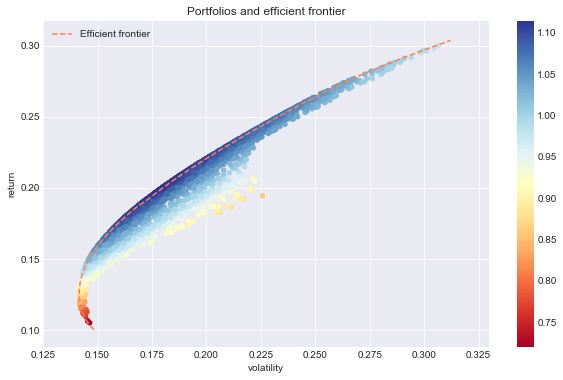

In [351]:
fig, ax = plt.subplots(1,1, figsize=(10,6)) 

im = ax.scatter(portfolios["volatility"], portfolios["return"], c=portfolios["sharpe ratio"], s=20, edgecolor=None, cmap='RdYlBu')
ax.set_title("Portfolios and efficient frontier")
ax.set_xlabel("volatility")
ax.set_ylabel("return")
ax.grid()

# Draw the efficient frontier
df = erk.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")
ax.set_xlim([0.125,0.33])

fig.colorbar(im, ax=ax)
plt.show()

**We will come back to the plot of the efficient frontier below**.

We can see that if the investor is targeting **a return of $20\%$** he could simply hold 
a portfolio **with volatility of about $18\%$**, although there are many other portfolios that 
can guarantee the same return but with much higher volatilities such as $28\%$. 
It is clear that one should carefully choose the weights of the portfolio. 

We can see, in particular, that there are two *important* portfolios:

1. the **portfolio with the lowest volatility**, i.e., the minimum variance portfolio
2. the **portfolio with the highest sharpe ratio**.

From the code above we can easily locate these two portfolios in our dataframe by looking at the lowest volatility and highest sharpe ratio 
and and recover the corresponding weights that have been stored.

In [352]:
# find the portfolio with lowest volatility 
low_vol_portfolio = portfolios.iloc[ portfolios['volatility'].idxmin() ]
print("Minimum volatility portfolio:")
print("- return      : {}".format(low_vol_portfolio[0]) )
print("- volatility  : {}".format(low_vol_portfolio[1]) )
print("- sharpe ratio: {}".format(low_vol_portfolio[2]) )

# find the portfolio with highest sharpe ratio
high_sharpe_portfolio = portfolios.iloc[ portfolios['sharpe ratio'].idxmax() ]
print("\nHighest sharpe ratio portfolio:")
print("- return      : {}".format(high_sharpe_portfolio[0]) )
print("- volatility  : {}".format(high_sharpe_portfolio[1]) )
print("- sharpe ratio: {}".format(high_sharpe_portfolio[2]) )

Minimum volatility portfolio:
- return      : 0.12584331558044698
- volatility  : 0.14156437074364306
- sharpe ratio: 0.8889476562456162

Highest sharpe ratio portfolio:
- return      : 0.19733316963647893
- volatility  : 0.17715330112735553
- sharpe ratio: 1.1139118965365262


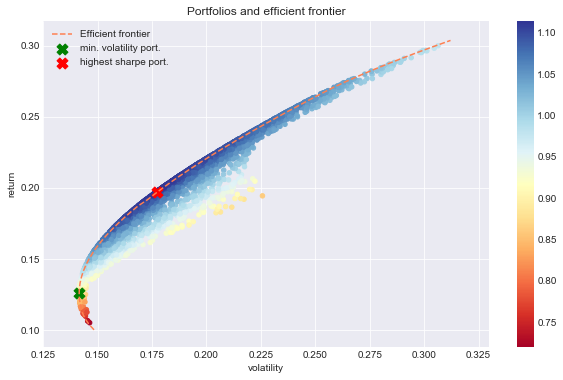

In [354]:
fig, ax = plt.subplots(1,1, figsize=(10,6)) 

im = ax.scatter(portfolios["volatility"], portfolios["return"], c=portfolios["sharpe ratio"], s=20, edgecolor=None, label=None, cmap='RdYlBu')
ax.set_title("Portfolios and efficient frontier")
ax.set_xlabel("volatility")
ax.set_ylabel("return")
ax.grid()

# Draw the efficient frontier
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")

ax.scatter(low_vol_portfolio[1],     low_vol_portfolio[0],     marker="X", color='g', s=120, label="min. volatility port.")
ax.scatter(high_sharpe_portfolio[1], high_sharpe_portfolio[0], marker="X", color='r', s=120, label="highest sharpe port.")

ax.set_xlim([0.125,0.33])
ax.legend()

fig.colorbar(im, ax=ax)
plt.show()

### Finding the optimal portfolios: minimizing the volatility 

In the experiments above, we found the optimal portfolios, i.e., the ones on the efficient frontier, by **simulating a high number of portfolios** and then plotting them. From the plot we could see what the efficient frontier looked like. 
However, we can find an optimal portfolio on the efficient frontier by **solving a minimization problem**, 
for example, by applying the **scipy optimize** method. 


For example, suppose we want to **find the portfolio (on the efficient frontier) which has the minimum volatility**. 
Then the minimization problem is:
$$
\text{minimize} \;\; \frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w}, 
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{1} = 1, \\
0 \leq \mathbf{w} \leq 1.
\end{cases}
$$

In [304]:
# Let us see the total (annual) returns of single companies we are investing in
ann_rets = erk.annualize_rets(daily_rets, periods_per_year)
ann_rets

AMZN    0.303673
KO      0.100365
MSFT    0.195947
dtype: float64

Now, we can call our minimizer which solves the minimization problem of finding the weights of the portfolio with minimum volatility. 

In [355]:
optimal_weights = erk.minimize_volatility(ann_rets, cov_rets)
print("optimal weights: {}".format(optimal_weights))

optimal weights: [0.05402656 0.79355662 0.15241682]


Cool. This means we should assign about **$5\%$, $79\%$, and $15\%$ to Amazon, Coca Cola, and Microsoft**, respectively. 

Let us compute the volatility of the portfolio constructed with these weights and locate it on the efficient frontier:

Portfolio return:       0.125768972440577
Portfolio volatility:   0.14156499806603942
Portfolio sharpe ratio: 0.8884185650319181


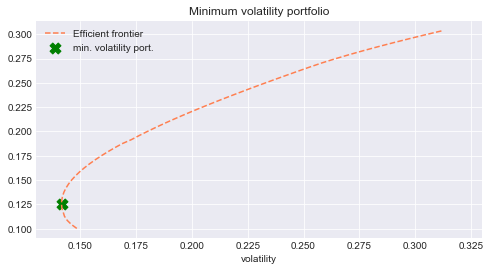

In [359]:
# portfolio volatility
vol = erk.portfolio_volatility(optimal_weights, cov_rets)
vol = erk.annualize_vol(vol, periods_per_year)

# portfolio return
ret = erk.portfolio_return(optimal_weights, ann_rets)

# portfolio sharpe ratio
shp = erk.sharpe_ratio(ret, risk_free_rate, periods_per_year, v=vol)

print("Portfolio return:       {}" .format(ret))
print("Portfolio volatility:   {}" .format(vol))
print("Portfolio sharpe ratio: {}" .format(shp))


# Draw the efficient frontier
fig, ax = plt.subplots(1,1, figsize=(8,4)) 
df = erk.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")
ax.scatter(vol, ret,  marker="X", color='g', s=120, label="min. volatility port.")
ax.set_xlim([0.13,0.33])
ax.legend()
ax.set_title("Minimum volatility portfolio")
plt.show()

We can also verify that the minimum volatility portfolio obtained by solving the minimization problem almost coincides 
with the one obtained from simulating a high number of portfolios as we have done before: 

In [364]:
print("Minimum volatility portfolio:")
print("- Monte carlo:")
print("  return:       {}" .format(low_vol_portfolio[0]))
print("  volatility:   {}" .format(low_vol_portfolio[1]))
print("  sharpe ratio: {}" .format(low_vol_portfolio[2]))
print("\n- Minimization problem:")
print("  return:       {}" .format(ret))
print("  volatility:   {}" .format(vol))
print("  sharpe ratio: {}" .format(shp))

Minimum volatility portfolio:
- Monte carlo:
  return:       0.12584331558044698
  volatility:   0.14156437074364306
  sharpe ratio: 0.8889476562456162

- Minimization problem:
  return:       0.125768972440577
  volatility:   0.14156499806603942
  sharpe ratio: 0.8884185650319181


#### Finding the optimal portfolios: minimizing the volatility given a fixed return


What if we want to find the **portfolio (on the efficient frontier) with minimium volatility for a given a level of return**? 
In this case, we simply have to add a constrain in the minimization problem:
$$
\text{minimize} \;\; \frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w}, 
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{R} = R_0, \\
\mathbf{w}^T \mathbf{1} = 1, \\
0 \leq \mathbf{w} \leq 1.
\end{cases}
$$
where $R_0$ denotes a fixed level of expected return. For example, suppose we target the following total expected return $R_0=16\%$:

In [366]:
target_return = 0.16

Now, we can call again the minimizer with the option of solving the problem with the constrain for the given target return:

In [367]:
optimal_weights = erk.minimize_volatility(ann_rets, cov_rets, target_return)
print("optimal weights: {}".format(optimal_weights))

optimal weights: [0.19749111 0.59672451 0.20578438]


Let us compute the volatility of the portfolio constructed with these weights. 
Also, we double check that the corresponding return is the target return that we have chosen (i.e., $16\%$) and 
locate the portfolio on the efficient frontier:

Portfolio return:       0.16000000009586407
Portfolio volatility:   0.15043581447394766
Portfolio sharpe ratio: 1.0635765203609326


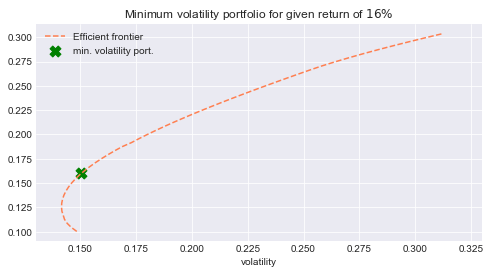

In [369]:
# portfolio volatility
vol = erk.portfolio_volatility(optimal_weights, cov_rets)
vol = erk.annualize_vol(vol, periods_per_year)

# portfolio return
ret = erk.portfolio_return(optimal_weights, ann_rets)

# portfolio sharpe ratio
shp = erk.sharpe_ratio(ret, risk_free_rate, periods_per_year, v=vol)

print("Portfolio return:       {}" .format(ret))
print("Portfolio volatility:   {}" .format(vol))
print("Portfolio sharpe ratio: {}" .format(shp))

fig, ax = plt.subplots(1,1, figsize=(8,4)) 

# Draw the efficient frontier
df = erk.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")
ax.scatter(vol, target_return,  marker="X", color='g', s=120, label="min. volatility port.")
ax.set_xlim([0.13,0.33])
ax.legend()
ax.set_title("Minimum volatility portfolio for given return of $16\%$")
plt.show()

Recall that **the return of a portfolio will be some value between the minimum and the maximum return from the assets composing the portfolio**. That is, given the same three companies, we cannot achieve a return of, say $40\%$ since the maximum return achievable is about $30\%$ from Amazon. 
In fact, if we run the minimizer with a target return equal to $40\%$ we will get zero weights to all assets but Amazon:

In [371]:
optimal_weights = erk.minimize_volatility(ann_rets, cov_rets, 0.4)
print(optimal_weights)

[1.00000000e+00 3.73152623e-18 1.68224695e-17]


In [288]:
optimal_weights = maximize_shape_ratio(ann_rets, cov_rets, risk_free_rate, periods_per_year)
print( optimal_weights )

[0.35336119 0.3786716  0.26796721]


In [289]:
vol = erk.portfolio_volatility(optimal_weights, cov_rets)
vol = erk.annualize_vol(vol, periods_per_year)

ret = erk.portfolio_return(optimal_weights, ann_rets)

shp = erk.sharpe_ratio(ret, risk_free_rate, periods_per_year, v=vol)

print("Portfolio return:       {}" .format(ret))
print("Portfolio volatility:   {}" .format(vol))
print("Portfolio sharpe ratio: {}" .format(shp))

Portfolio return:       0.19781884891306473
Portfolio volatility:   0.177388406782067
Portfolio sharpe ratio: 1.1151734913324851


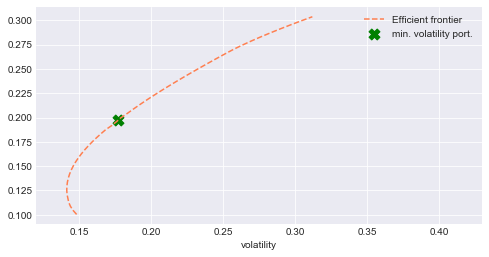

In [291]:
fig, ax = plt.subplots(1,1, figsize=(8,4)) 

# Draw the efficient frontier
df = erk.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")

ax.scatter(vol, ret,  marker="X", color='g', s=120, label="min. volatility port.")
ax.set_xlim([0.12,0.43])
ax.legend()

plt.show()

In [405]:
ww = minimize_volatility(0.151616, erk.annualize_rets(daily_rets, periods_per_year), cov_rets)
vv = erk.annualize_vol( erk.portfolio_volatility(ww, cov_rets), periods_per_year) 
rr = erk.portfolio_return(ww, erk.annualize_rets(daily_rets, periods_per_year))
print(ww)
print(vv*100)
print(rr*100)

[0.14210245 0.64130619 0.03107898 0.18551238]
14.62870641820395
15.161599999201133


### Finding the optimal portfolios: minimizing the volatility 

In the experiments above, we found the optimal portfolios, i.e., the ones on the efficient frontier, by **simulating a high number of portfolios** and then plotting them. From the plot we could see what the efficient frontier looked like. 
However, we can find an optimal portfolio on the efficient frontier by **solving a minimization problem**, 
for example, through the **scipy optimize** method. 

That is, we want to **find the portfolio (on the efficient frontier) which has the minimum volatility for a given level of return**. 
The minimization problem is:
$$
\text{minimize} \;\; \frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w}, 
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{R} = R_0, \\
\mathbf{w}^T \mathbf{1} = 1, \\
0 \leq \mathbf{w} \leq 1.
\end{cases}
$$

Here, $R_0$ is a known level of expected return. 

Let us consider the following data set of **industry monthly returns**:

In [239]:
ind = erk.get_ind_returns()
ind.tail()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2018-08-01,-0.0038,-0.0186,-0.0543,0.0289,-0.0447,0.0254,0.0526,0.0446,0.0001,0.0380,...,0.0295,0.0524,0.0993,-0.0034,0.0291,0.0366,0.0911,0.0364,0.0245,0.0299
2018-09-01,-0.0032,0.0019,0.0537,-0.0009,-0.0221,0.0107,0.0130,0.0199,-0.0287,-0.0638,...,0.0174,-0.0037,-0.0033,-0.0030,0.0105,-0.0148,0.0061,0.0251,-0.0193,0.0116
2018-10-01,0.0102,-0.0157,0.0790,-0.1596,-0.0666,-0.0051,-0.1014,-0.0884,-0.1250,-0.2579,...,-0.0050,-0.0920,-0.0806,-0.0982,-0.0975,-0.0788,-0.1021,-0.0171,-0.0545,-0.0599
2018-11-01,0.0272,0.0579,-0.0843,-0.0065,0.0325,0.0644,-0.0099,0.0632,0.0496,0.0292,...,0.0254,0.0129,-0.0505,0.0822,0.0617,0.0318,0.0159,0.0616,0.0289,0.0348
2018-12-01,-0.0973,-0.0969,-0.1580,-0.0824,-0.1535,-0.0557,-0.0728,-0.0840,-0.0776,-0.1009,...,-0.0884,-0.0765,-0.0923,-0.0863,-0.1519,-0.1121,-0.0919,-0.0628,-0.1144,-0.0693


Let us just plot the VaRs of the industry indices and their sharpe ratio.

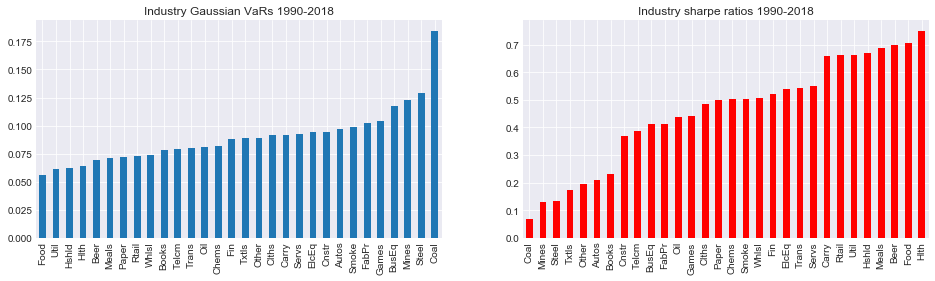

In [240]:
fig, ax = plt.subplots(figsize=(20,4), nrows=1, ncols=2)
erk.var_gaussian(ind["1990":"2018"], cf=True).sort_values().plot.bar(grid=True, figsize=(16,4), ax=ax[0], title="Industry Gaussian VaRs 1990-2018")
erk.sharpe_ratio(ind["1990":"2018"], 0.0, 12).sort_values().plot.bar(grid=True, figsize=(16,4), ax=ax[1], title="Industry sharpe ratios 1990-2018", color="r")
plt.show()

For example, let us consider a portfolio of the $4$ assets:

In [249]:
periods_per_year = 12
sectors          = ["Food","Smoke","Fin","Oil"]  #["Food","Smoke","Coal","Fin"]
monthly_rets     = erk.get_ind_returns()["1990":][sectors]

# covariance matrix
covmat = monthly_rets.cov()
covmat

,Food,Smoke,Fin,Oil
Food,0.001530,0.001423,0.001284,0.000803
Smoke,0.001423,0.004447,0.001040,0.000888
Fin,0.001284,0.001040,0.003035,0.001456
Oil,0.000803,0.000888,0.001456,0.002940


In [250]:
# Let us see the total returns of single companies we are investing in
ann_rets = erk.annualize_rets(monthly_rets, periods_per_year)
ann_rets

Food     0.095838
Smoke    0.116354
Fin      0.099300
Oil      0.082143
dtype: float64

In [251]:
# and suppose we target the following total expected return
target_return = 0.10
# which is a return between the minimum return (0.29% from Coal) and the maximum return (11.6% from Smoke) of our hypothetical portfolio

Now, we can call our minimizer which solves the minimization problem of finding the weights of the portfolio with minimum volatility among those one yielding a given return.

In [252]:
optimal_weights = erk.minimize_volatility(target_return, ann_rets, covmat)
print(optimal_weights)

[0.56608838 0.21602074 0.1582076  0.05968328]


Fine. We see that we basically have to assign **zero weight to Coal**. Let us compute the volatility of a portfolio constructed with these weights, and double check that the corresponding return is the target return that we have chosen (i.e., $10\%$):

In [253]:
vol = erk.portfolio_volatility(optimal_weights, covmat)
vol = erk.annualize_vol(vol, periods_per_year)

ret = erk.portfolio_return(optimal_weights, ann_rets)

shp = erk.sharpe_ratio(ret, risk_free_rate, periods_per_year, v=vol)

print("Portfolio return:       {}" .format(ret))
print("Portfolio volatility:   {}" .format(vol))
print("Portfolio sharpe ratio: {}" .format(shp))

Portfolio return:       0.0999999999947655
Portfolio volatility:   0.13584553062342927
Portfolio sharpe ratio: 0.7361302174303443


Right, and now let us plot the efficient frontier with such a portfolio:

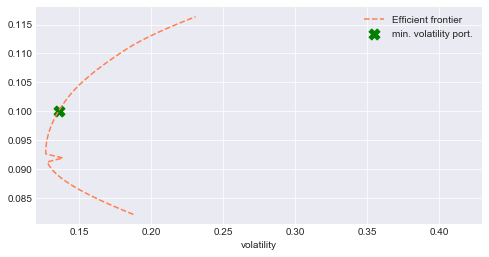

In [254]:
fig, ax = plt.subplots(1,1, figsize=(8,4)) 

# Draw the efficient frontier
df = erk.efficient_frontier(50, monthly_rets, covmat, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")

ax.scatter(vol, target_return,  marker="X", color='g', s=120, label="min. volatility port.")
ax.set_xlim([0.12,0.43])
ax.legend()

plt.show()

Recall that **the return of a portfolio will be some value between the minimum and the maximum return from the assets composing the portfolio**. That if, with the same four companies chosen, we could not achieve a return of, say $15\%$ since the maximum return achievable is $11.6\%$ from Smoke. 

In fact, if we run the minimizer with a target return equal to $15\%$ we will get zero weights to each asset but Smoke:

In [255]:
optimal_weights = erk.minimize_volatility(0.15, ann_rets, covmat)
print(optimal_weights)

[4.58046674e-15 1.00000000e+00 1.68341252e-12 2.77195730e-16]


i.e., $w_2=1$ and $w_0=w_3=w_4=0$ as expected.

### Finding the optimal portfolios: maximimzing the sharpe ratio 

What if we were to finding the portfolio (on the efficient frontier) with the highest sharpe ratio? 
Note that scipy offers a **minimize** method, but no a **maximize** a method, and we may then conclude 
that we are not able to find such a portfolio by solving an optimization problem. 

However, **the maximization of the sharpe ratio is nothing but the minimization of the negative sharpe ratio**. 
That is, given a certain level of volatility, 


we can find our portfolio by solving the minimization problem:
$$
\text{maximize} \;\; -  \frac{R_p - r_f}{\sigma_p} =: \text{SR} 
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{R} = R_0, \\
\mathbf{w}^T \mathbf{1} = 1, \\
0 \leq \mathbf{w} \leq 1.
\end{cases}
$$

Here, $R_0$ is a known level of expected return. 

Let us consider the following data set of **industry monthly returns**:

In [256]:
risk_free_rate   = 0.0
periods_per_year = 12
sectors          = ["Food","Smoke","Fin","Oil"]    #["Food","Smoke","Coal","Fin"]
monthly_rets     = erk.get_ind_returns()["1990":][sectors]

# covariance matrix
covmat = monthly_rets.cov()
covmat

,Food,Smoke,Fin,Oil
Food,0.001530,0.001423,0.001284,0.000803
Smoke,0.001423,0.004447,0.001040,0.000888
Fin,0.001284,0.001040,0.003035,0.001456
Oil,0.000803,0.000888,0.001456,0.002940


In [257]:
# Let us see the total returns of single companies we are investing in
ann_rets = erk.annualize_rets(monthly_rets, periods_per_year)
ann_rets

Food     0.095838
Smoke    0.116354
Fin      0.099300
Oil      0.082143
dtype: float64

In [287]:
def neg_portfolio_sharpe_ratio(weights, rets, covmatrix, risk_free_rate, periods_per_year):
    '''
    Computes the annualized sharpe ratio. 
    The variable periods_per_year can be, e.g., 12, 52, 252, in case of yearly, weekly, and daily data.
    The variable risk_free_rate is the annual one.
    The method takes in input either a DataFrame, a Series or a single number. 
    In the former case, it computes the annualized sharpe ratio of every column (Series) by using pd.aggregate. 
    In the latter case, s is the (allready annualized) return and v is the (already annualized) volatility 
    computed beforehand, for example, in case of a portfolio.
    '''
    # annualized portfolio returns
    portfolio_ret = erk.portfolio_return(weights, rets)        

    # annualized portfolio volatility
    portfolio_vol = erk.portfolio_volatility(weights, covmatrix)
    portfolio_vol = erk.annualize_vol(portfolio_vol, periods_per_year)

    #return - (portfolio_ret - risk_free_rate) / portfolio_vol
    return - erk.sharpe_ratio(portfolio_ret, risk_free_rate, periods_per_year, v=portfolio_vol)
    
def maximize_shape_ratio(rets, covmatrix, risk_free_rate, periods_per_year):
    '''
    Returns the optimal weights corresponding to the minimum volatility
    portfolio constructed by fixing an expected target_return. 
    Such a portfolio lies on the efficient frontier.
    '''
    #return_constraint = {
     #   "type": "eq",  # means that the constraint is an equality
      #  "args": (rets,),
       # "fun": lambda w, r: target_return - portfolio_return(w, r)
    #}
    n_assets   = rets.shape[0] 
    init_guess = np.repeat(1/n_assets, n_assets)
    weights_constraint = {
        "type": "eq",
        "fun": lambda w: 1.0 - np.sum(w)  
    }
    result = minimize(neg_portfolio_sharpe_ratio,
                      init_guess,
                      args = (rets, covmatrix, risk_free_rate, periods_per_year),
                      method = "SLSQP",
                      options = {"disp": False},
                      constraints = (weights_constraint),
                      bounds = ((0.0,1.0),)*n_assets)
    return result.x

In [259]:
optimal_weights = maximize_shape_ratio(ann_rets, covmat, risk_free_rate, periods_per_year)
print( optimal_weights )

[0.63881043 0.12390908 0.08926431 0.14801618]


In [260]:
vol = erk.portfolio_volatility(optimal_weights, covmat)
vol = erk.annualize_vol(vol, periods_per_year)

ret = erk.portfolio_return(optimal_weights, ann_rets)

shp = erk.sharpe_ratio(ret, risk_free_rate, periods_per_year, v=vol)


print("Portfolio return:       {}" .format(ret))
print("Portfolio volatility:   {}" .format(vol))
print("Portfolio sharpe ratio: {}" .format(shp))

Portfolio return:       0.0966618521493947
Portfolio volatility:   0.1295526536443429
Portfolio sharpe ratio: 0.7461202023291444


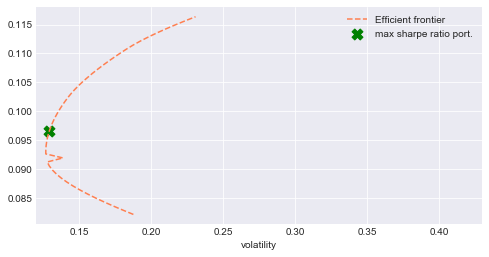

In [261]:
fig, ax = plt.subplots(1,1, figsize=(8,4)) 

# Draw the efficient frontier
df = erk.efficient_frontier(50, monthly_rets, covmat, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")

ax.scatter(vol, ret,  marker="X", color='g', s=120, label="max sharpe ratio port.")
ax.set_xlim([0.12,0.43])
ax.legend()

plt.show()